# Some plots and analysis of simulation data

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

## Simulation Parameters

In [249]:
test_info = pd.read_csv("../data/backup/stats_mlfd/test_info.csv")
test_info

,test,workersCount,locationsCount,sampleSize,defaultMean,hbTimeout,randomMillis,geoFactor,crashProb,delta
0,mlfd_test,100,100,100,3000.0,4 seconds,200,100.0,0.001,NaN


## Prediction Evaluation of the Online-learner in the FD

In [104]:
test_evaluations = pd.read_csv("../data/backup/stats_mlfd/testresults.csv")
test_evaluations.head()

,meanSquaredError,rootMeanSquaredError,rSquared,meanAbsoluteError,explainedVariance,timestamp
0,2.891005e+06,1700.295700,-0.815136,1418.753397,6.844245e+06,1504424870000
1,2.135465e+05,462.110885,0.974527,349.727503,1.041643e+07,1504424876000
2,1.632067e+04,127.752381,0.996729,105.777594,5.328207e+06,1504424883000
3,4.299215e+03,65.568400,0.999504,56.537756,8.820089e+06,1504424888000
4,3.624345e+03,60.202532,0.999099,48.894390,4.148113e+06,1504424895000


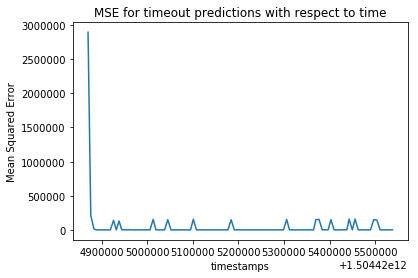

In [105]:
time = test_evaluations["timestamp"].values
mse = test_evaluations["meanSquaredError"].values
plt.plot(time, mse)
plt.ylabel('Mean Squared Error')
plt.xlabel('timestamps')
plt.title('MSE for timeout predictions with respect to time')
plt.show()

## RTT Distributions related to geographic location

In [138]:
rtt_data = pd.read_csv('../data/backup/stats_mlfd/rtt_data.csv')

In [139]:
rtt_data.head()

,node,geoLocation,rtt,timestamp,mean
0,100,0,270.0,1504424862481,270.0
1,1,1,338.0,1504424862550,338.0
2,2,2,548.0,1504424862760,548.0
3,3,3,599.0,1504424862811,599.0
4,4,4,648.0,1504424862860,648.0


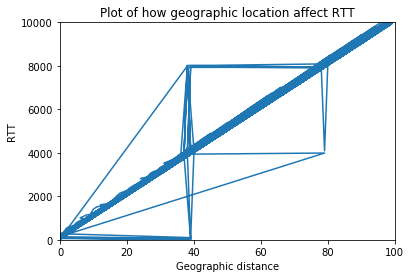

In [140]:
geo = rtt_data["geoLocation"].values
rtt = rtt_data["rtt"].values
plt.plot(geo, rtt)
plt.axis([0, 100, 0, 10000])
plt.ylabel('RTT')
plt.xlabel('Geographic distance')
plt.title('Plot of how geographic location affect RTT')
plt.show()

In [173]:
rtt_data_with_mean = rtt_data.groupby(['geoLocation', 'rtt'], as_index=False).mean().groupby('geoLocation')['rtt'].mean()
rtt_data_with_mean.head()

geoLocation
0    131.860000
1    226.456522
2    325.627907
3    427.609756
4    530.630435
Name: rtt, dtype: float64

In [246]:
rtt_data_with_std = rtt_data.groupby('geoLocation')[['rtt']].std()
rtt_data_with_std.head()

,rtt
geoLocation,
0,58.987944
1,57.103708
2,61.323999
3,59.254465
4,60.819616


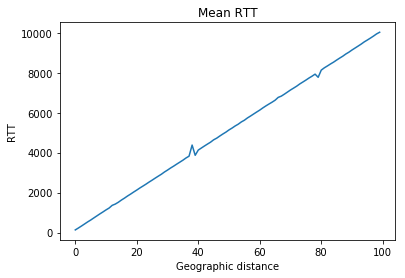

In [220]:
plt.plot(rtt_data_with_mean)
#plt.axis([0, 100, 0, 10000])
plt.ylabel('RTT')
plt.xlabel('Geographic distance')
plt.title('Mean RTT Plot by Geographic distance')
plt.show()

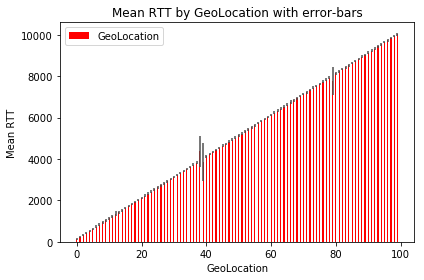

In [244]:
rtt = rtt_data_with_mean.values
std = rtt_data_with_std.values
l = len(rtt)
width = 0.35
error_config = {'ecolor': '0.3'}
plt.bar(range(len(rtt)), rtt, width=width, color='r', yerr=std, error_kw=error_config, label='GeoLocation')
plt.xlabel('GeoLocation')
plt.ylabel('Mean RTT')
plt.title('Mean RTT by GeoLocation with error-bars')
plt.legend()
plt.tight_layout()

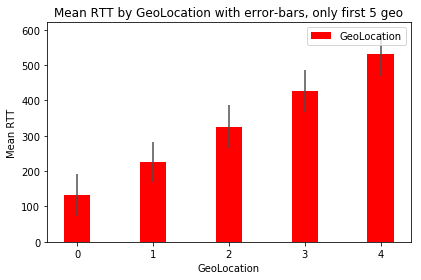

In [248]:
rtt = rtt_data_with_mean.head().values
std = rtt_data_with_std.head().values
l = len(rtt)
width = 0.35
error_config = {'ecolor': '0.3'}
plt.bar(range(len(rtt)), rtt, width=width, color='r', yerr=std, error_kw=error_config, label='GeoLocation')
plt.xlabel('GeoLocation')
plt.ylabel('Mean RTT')
plt.title('Mean RTT by GeoLocation with error-bars, only first 5 geo')
plt.legend()
plt.tight_layout()

## Predictions for a single Node

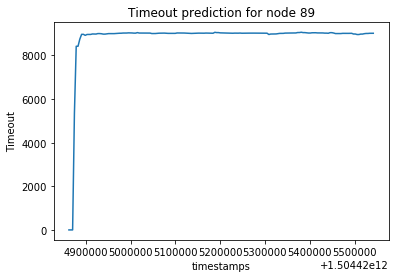

In [109]:
prediction_data = pd.read_csv('../data/backup/stats_mlfd/prediction_data.csv')
node89 = prediction_data.loc[prediction_data['node'] == 89]
time = node89["timestamp"].values
prediction = node89["prediction"].values
plt.plot(time, prediction)
plt.ylabel('Timeout')
plt.xlabel('timestamps')
plt.title('Timeout prediction for node 89')
plt.show()

## RTT-data for a single Node

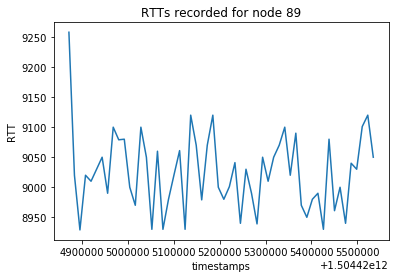

In [110]:
node89 = rtt_data.loc[rtt_data['node'] == 89]
time = node89["timestamp"].values
prediction = node89["rtt"].values
plt.plot(time, prediction)
plt.ylabel('RTT')
plt.xlabel('timestamps')
plt.title('RTTs recorded for node 89')
plt.show()

## Analysis of number of suspected nodes with respect to time

In [111]:
suspected_nodes_data = pd.read_csv('../data/backup/stats_mlfd/suspected_nodes.csv')
suspected_nodes_data.head()

,timestamp,numberOfSuspectedNodes
0,1504424862212,0
1,1504424866440,0
2,1504424870471,61
3,1504424874490,20
4,1504424878510,0


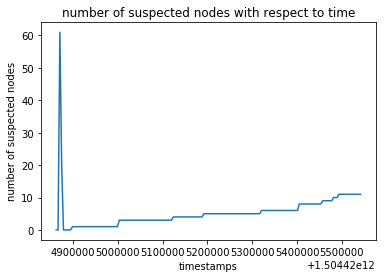

In [112]:
time = suspected_nodes_data["timestamp"].values
suspected = suspected_nodes_data["numberOfSuspectedNodes"].values
plt.plot(time, suspected)
plt.ylabel('number of suspected nodes')
plt.xlabel('timestamps')
plt.title('number of suspected nodes with respect to time')
plt.show()

In [113]:
node_crashes = pd.read_csv('../data/backup/stats_mlfd/node_crashes.csv')
node_suspicions = pd.read_csv('../data/backup/stats_mlfd/node_suspicions.csv')

In [114]:
node_suspicions = pd.merge(node_suspicions, node_crashes, how="inner", on="node")
node_suspicions = node_suspicions.sort_values('suspected', ascending=False).drop_duplicates('node').sort_index()

In [115]:
node_suspicions["detection_time"] = node_suspicions["suspected"] - node_suspicions["timestamp"]

In [116]:
node_suspicions = node_suspicions[node_suspicions["detection_time"]>0] #Remove premature suspicion

In [117]:
node_suspicions

,node,suspected,timestamp,detection_time
1,91,1504425188050,1504425184031,4019
3,54,1504425119710,1504425115691,4019
6,66,1504424999110,1504424995091,4019
8,97,1504425453370,1504425441311,12059
10,73,1504424999110,1504424991072,8038
12,63,1504425401110,1504425393071,8039
14,74,1504425489550,1504425481511,8039
15,12,1504424894591,1504424890574,4017
16,14,1504425316690,1504425312671,4019
17,22,1504425401110,1504425397092,4018


## Mean RTT per node

In [118]:
#rtt_data calculate mean per node and merge
mean_rtt = rtt_data.groupby(['node', 'rtt'], as_index=False).mean().groupby('node')['rtt'].mean()

In [120]:
matrix = mean_rtt.as_matrix
mean = np.array(mean_rtt)

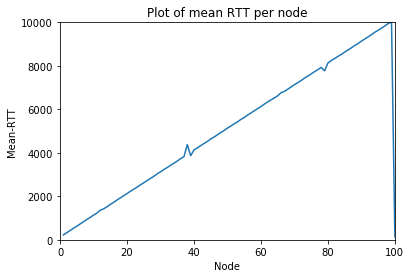

In [121]:
plt.plot(mean_rtt)
plt.axis([0, 100, 0, 10000])
plt.ylabel('Mean-RTT')
plt.xlabel('Node')
plt.title('Plot of mean RTT per node')
plt.show()

## False suspicions per timeout

In [164]:
node_suspicions2 = pd.read_csv('../data/backup/stats_mlfd/node_suspicions.csv')
keys = ['suspected', "node"]
i1 = node_suspicions2.set_index(keys).index
i2 = node_suspicions.set_index(keys).index
false_suspicions = node_suspicions2[~i1.isin(i2)]
false_suspicions = false_suspicions.groupby("suspected").count()
false_suspicions

,node
suspected,
1504424866440,61


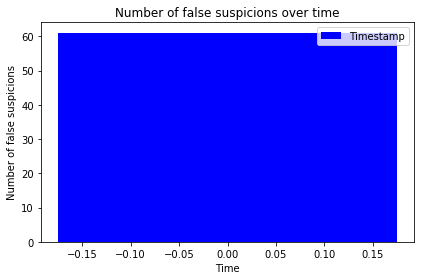

In [281]:
mlfd_false_suspicions = false_suspicions.values
l = len(epfd_false_suspicions)
width = 0.35
error_config = {'ecolor': '0.3'}
plt.bar(range(len(mlfd_false_suspicions)), mlfd_false_suspicions, width=width, color='b', error_kw=error_config, label='Timestamp')
plt.xlabel('Time')
plt.ylabel('Number of false suspicions')
plt.title('Number of false suspicions over time')
plt.legend()
plt.tight_layout()

## Time a node was suspected - time node actually crashed, plotted with respect to mean RTT

In [122]:
mean_n = np.zeros(len(node_suspicions["node"]))
j = 0
for i in range(0, len(mean)):
    if(i in node_suspicions["node"].values):
        #print(i)
        mean_n[j] = mean[i]
        j = j+1

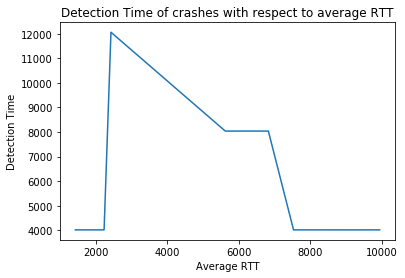

In [123]:
plt.plot(mean_n, node_suspicions["detection_time"])
plt.ylabel('Detection Time')
plt.xlabel('Average RTT')
plt.title('Detection Time of crashes with respect to average RTT')
plt.show()

## Implementation of an Offline-model to analyze the data, using Keras+Tensorflow

In [126]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score

mean_geo_data = rtt_data.drop(["node", "timestamp"], 1)
#mean_geo_data = mean_geo_data[["geoLocation","rtt","mean"]].apply(pd.to_numeric)
df_train, df_test = np.split(mean_geo_data.sample(frac=1), [int(.8*len(mean_geo_data))])
Y_train = df_train["rtt"].values
Y_test = df_test["rtt"].values
X_train = df_train.drop("rtt", 1).values
X_test = df_test.drop("rtt", 1).values

In [127]:
mean_geo_data.head()

,geoLocation,rtt,mean
0,0,270.0,270.0
1,1,338.0,338.0
2,2,548.0,548.0
3,3,599.0,599.0
4,4,648.0,648.0


In [128]:
# create model
model = Sequential()
model.add(Dense(20, input_dim=2, init='uniform', activation='tanh'))
model.add(Dense(1, init='uniform', activation='linear'))

# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X_train, Y_train, nb_epoch=1000, batch_size=10,  verbose=2)

# Calculate predictions
PredTestSet = model.predict(X_train)
PredValSet = model.predict(X_test)

# Save predictions
np.savetxt("trainresults.csv", PredTestSet, delimiter=",")
np.savetxt("valresults.csv", PredValSet, delimiter=",")

/home/limmen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(20, input_dim=2, activation="tanh", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/limmen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="linear", kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/home/limmen/anaconda3/lib/python3.6/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1000
0s - loss: 23086801.0035 - acc: 0.0000e+00
Epoch 2/1000
0s - loss: 22948385.7583 - acc: 0.0000e+00
Epoch 3/1000
0s - loss: 22810687.8092 - acc: 1.1703e-04
Epoch 4/1000
0s - loss: 22673897.5723 - acc: 0.0000e+00
Epoch 5/1000
0s - loss: 22537339.0164 - acc: 1.1703e-04
Epoch 6/1000
0s - loss: 22401447.3245 - acc: 0.0000e+00
Epoch 7/1000
0s - loss: 22266624.9005 - acc: 1.1703e-04
Epoch 8/1000
0s - loss: 22132150.7109 - acc: 1.1703e-04
Epoch 9/1000
0s - loss: 21998333.2203 - acc: 1.1703e-04
Epoch 10/1000
0s - loss: 21865394.1104 - acc: 1.1703e-04
Epoch 11/1000
0s - loss: 21733002.2926 - acc: 2.3406e-04
Epoch 12/1000
0s - loss: 21601279.3347 - acc: 1.1703e-04
Epoch 13/1000
0s - loss: 21470001.3520 - acc: 1.1703e-04
Epoch 14/1000
0s - loss: 21339395.9067 - acc: 0.0000e+00
Epoch 15/1000
0s - loss: 21209498.5660 - acc: 1.1703e-04
Epoch 16/1000
0s - loss: 21080234.1170 - acc: 0.0000e+00
Epoch 17/1000
0s - loss: 20951599.2917 - acc: 2.3406e-04
Epoch 18/1000
0s - loss: 20823522.4225 -

0s - loss: 9651618.0388 - acc: 0.0012
Epoch 148/1000
0s - loss: 9581753.3319 - acc: 0.0019
Epoch 149/1000
0s - loss: 9512893.7334 - acc: 0.0016
Epoch 150/1000
0s - loss: 9446528.5622 - acc: 0.0012
Epoch 151/1000
0s - loss: 9378415.7847 - acc: 0.0011
Epoch 152/1000
0s - loss: 9312272.0611 - acc: 0.0014
Epoch 153/1000
0s - loss: 9246248.5547 - acc: 0.0012
Epoch 154/1000
0s - loss: 9179409.4296 - acc: 0.0018
Epoch 155/1000
0s - loss: 9116334.9700 - acc: 0.0012
Epoch 156/1000
0s - loss: 9049373.7127 - acc: 0.0018
Epoch 157/1000
0s - loss: 8982412.7264 - acc: 0.0012
Epoch 158/1000
0s - loss: 8918981.2181 - acc: 0.0014
Epoch 159/1000
0s - loss: 8854578.6175 - acc: 0.0012
Epoch 160/1000
0s - loss: 8790065.9315 - acc: 0.0012
Epoch 161/1000
0s - loss: 8728227.5169 - acc: 4.6811e-04
Epoch 162/1000
0s - loss: 8662796.3356 - acc: 0.0011
Epoch 163/1000
0s - loss: 8602152.6018 - acc: 9.3622e-04
Epoch 164/1000
0s - loss: 8539042.9380 - acc: 9.3622e-04
Epoch 165/1000
0s - loss: 8476556.1621 - acc: 0.0

0s - loss: 5147788.9582 - acc: 0.0013
Epoch 301/1000
0s - loss: 5105541.6419 - acc: 9.3622e-04
Epoch 302/1000
0s - loss: 5066496.2063 - acc: 0.0015
Epoch 303/1000
0s - loss: 5025094.9212 - acc: 0.0014
Epoch 304/1000
0s - loss: 5219357.4929 - acc: 0.0012
Epoch 305/1000
0s - loss: 6235611.9690 - acc: 7.0217e-04
Epoch 306/1000
0s - loss: 6187801.7257 - acc: 5.8514e-04
Epoch 307/1000
0s - loss: 6141242.8544 - acc: 0.0011
Epoch 308/1000
0s - loss: 6099377.0106 - acc: 7.0217e-04
Epoch 309/1000
0s - loss: 6052291.4738 - acc: 0.0011
Epoch 310/1000
0s - loss: 6002033.7888 - acc: 7.0217e-04
Epoch 311/1000
0s - loss: 5975790.3046 - acc: 7.0217e-04
Epoch 312/1000
0s - loss: 5913966.6236 - acc: 0.0012
Epoch 313/1000
0s - loss: 5885628.4882 - acc: 8.1919e-04
Epoch 314/1000
0s - loss: 5836807.9212 - acc: 0.0012
Epoch 315/1000
0s - loss: 5783378.2895 - acc: 9.3622e-04
Epoch 316/1000
0s - loss: 5741729.2582 - acc: 0.0012
Epoch 317/1000
0s - loss: 5708169.7410 - acc: 0.0019
Epoch 318/1000
0s - loss: 565

0s - loss: 7214833.4241 - acc: 8.1919e-04
Epoch 448/1000
0s - loss: 7182000.4469 - acc: 1.1703e-04
Epoch 449/1000
0s - loss: 7149562.6681 - acc: 1.1703e-04
Epoch 450/1000
0s - loss: 7116536.1657 - acc: 1.1703e-04
Epoch 451/1000
0s - loss: 7083443.6736 - acc: 0.0000e+00
Epoch 452/1000
0s - loss: 7054654.6071 - acc: 4.6811e-04
Epoch 453/1000
0s - loss: 7021230.1227 - acc: 3.5108e-04
Epoch 454/1000
0s - loss: 6993866.5787 - acc: 3.5108e-04
Epoch 455/1000
0s - loss: 6966057.7755 - acc: 2.3406e-04
Epoch 456/1000
0s - loss: 6933997.3327 - acc: 4.6811e-04
Epoch 457/1000
0s - loss: 6903793.5870 - acc: 2.3406e-04
Epoch 458/1000
0s - loss: 6876915.2954 - acc: 2.3406e-04
Epoch 459/1000
0s - loss: 6862527.3014 - acc: 2.3406e-04
Epoch 460/1000
0s - loss: 6817133.5005 - acc: 1.1703e-04
Epoch 461/1000
0s - loss: 6792464.9793 - acc: 3.5108e-04
Epoch 462/1000
0s - loss: 6763841.4086 - acc: 1.1703e-04
Epoch 463/1000
0s - loss: 6737857.6154 - acc: 4.6811e-04
Epoch 464/1000
0s - loss: 6760257.4871 - acc: 

0s - loss: 7430971.0468 - acc: 2.3406e-04
Epoch 592/1000
0s - loss: 7428360.5059 - acc: 1.1703e-04
Epoch 593/1000
0s - loss: 7425889.4696 - acc: 0.0000e+00
Epoch 594/1000
0s - loss: 7423495.8986 - acc: 1.1703e-04
Epoch 595/1000
0s - loss: 7421203.9557 - acc: 2.3406e-04
Epoch 596/1000
0s - loss: 7418994.3126 - acc: 0.0000e+00
Epoch 597/1000
0s - loss: 7416886.2614 - acc: 0.0000e+00
Epoch 598/1000
0s - loss: 7414854.4157 - acc: 3.5108e-04
Epoch 599/1000
0s - loss: 7412915.3117 - acc: 0.0000e+00
Epoch 600/1000
0s - loss: 7411023.3331 - acc: 8.1919e-04
Epoch 601/1000
0s - loss: 7409195.7885 - acc: 0.0000e+00
Epoch 602/1000
0s - loss: 7407449.8392 - acc: 8.1919e-04
Epoch 603/1000
0s - loss: 7405744.9327 - acc: 0.0000e+00
Epoch 604/1000
0s - loss: 7404146.4338 - acc: 0.0000e+00
Epoch 605/1000
0s - loss: 7402635.1733 - acc: 4.6811e-04
Epoch 606/1000
0s - loss: 7401187.5518 - acc: 0.0000e+00
Epoch 607/1000
0s - loss: 7399775.3237 - acc: 2.3406e-04
Epoch 608/1000
0s - loss: 7398380.0455 - acc: 

0s - loss: 7365553.3808 - acc: 4.6811e-04
Epoch 736/1000
0s - loss: 7365547.1166 - acc: 2.3406e-04
Epoch 737/1000
0s - loss: 7365544.1036 - acc: 2.3406e-04
Epoch 738/1000
0s - loss: 7365535.4032 - acc: 0.0000e+00
Epoch 739/1000
0s - loss: 7365530.6260 - acc: 0.0000e+00
Epoch 740/1000
0s - loss: 7365521.2896 - acc: 0.0000e+00
Epoch 741/1000
0s - loss: 7365521.5505 - acc: 0.0000e+00
Epoch 742/1000
0s - loss: 7365513.8774 - acc: 0.0000e+00
Epoch 743/1000
0s - loss: 7365512.6240 - acc: 0.0000e+00
Epoch 744/1000
0s - loss: 7365505.4343 - acc: 0.0000e+00
Epoch 745/1000
0s - loss: 7365502.2414 - acc: 0.0000e+00
Epoch 746/1000
0s - loss: 7365494.0674 - acc: 0.0000e+00
Epoch 747/1000
0s - loss: 7365491.2206 - acc: 0.0000e+00
Epoch 748/1000
0s - loss: 7365487.0556 - acc: 0.0000e+00
Epoch 749/1000
0s - loss: 7365483.5183 - acc: 0.0000e+00
Epoch 750/1000
0s - loss: 7365481.4198 - acc: 0.0000e+00
Epoch 751/1000
0s - loss: 7365474.1262 - acc: 0.0000e+00
Epoch 752/1000
0s - loss: 7365474.2585 - acc: 

0s - loss: 7365394.9871 - acc: 0.0000e+00
Epoch 881/1000
0s - loss: 7365393.1460 - acc: 0.0000e+00
Epoch 882/1000
0s - loss: 7365392.3850 - acc: 0.0000e+00
Epoch 883/1000
0s - loss: 7365393.6635 - acc: 0.0000e+00
Epoch 884/1000
0s - loss: 7365399.5097 - acc: 0.0000e+00
Epoch 885/1000
0s - loss: 7365388.9974 - acc: 0.0000e+00
Epoch 886/1000
0s - loss: 7365391.3264 - acc: 0.0000e+00
Epoch 887/1000
0s - loss: 7365393.1483 - acc: 0.0000e+00
Epoch 888/1000
0s - loss: 7365392.3798 - acc: 0.0000e+00
Epoch 889/1000
0s - loss: 7365391.5184 - acc: 0.0000e+00
Epoch 890/1000
0s - loss: 7365395.2177 - acc: 0.0000e+00
Epoch 891/1000
0s - loss: 7365391.2527 - acc: 0.0000e+00
Epoch 892/1000
0s - loss: 7365392.0101 - acc: 0.0000e+00
Epoch 893/1000
0s - loss: 7365394.0032 - acc: 0.0000e+00
Epoch 894/1000
0s - loss: 7365396.9206 - acc: 0.0000e+00
Epoch 895/1000
0s - loss: 7365391.6916 - acc: 0.0000e+00
Epoch 896/1000
0s - loss: 7365393.9293 - acc: 0.0000e+00
Epoch 897/1000
0s - loss: 7365392.8803 - acc: 

Training Set R-Square= -3.14845927107e-11


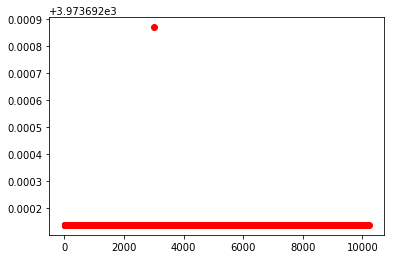

In [129]:
#Plot actual vs predition for training set
TestResults = np.genfromtxt("trainresults.csv", delimiter=",")
plt.plot(Y_train,TestResults,'ro')

#Compute R-Square value for training set
TestR2Value = r2_score(Y_train,TestResults)
print("Training Set R-Square=", TestR2Value)

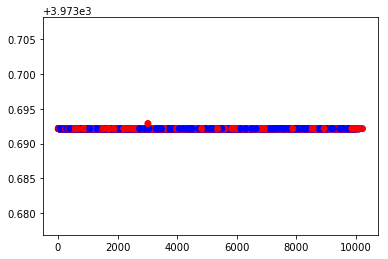

In [130]:
plt.scatter(Y_train, TestResults,color=["red", "blue"])
plt.show()

## Another offline model, using sklearn

In [132]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model

lr = linear_model.LinearRegression()

predicted = cross_val_predict(lr, X_train, Y_train, cv=10)

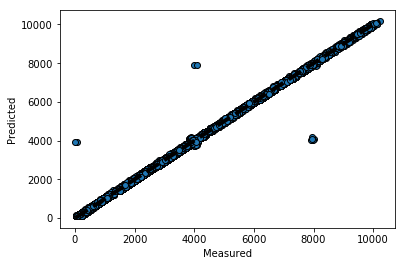

In [135]:
fig, ax = plt.subplots()
ax.scatter(Y_train, predicted, edgecolors=(0, 0, 0))
ax.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## Comparison MLFD vs EPFD

In [255]:
node_crashes_epfd = pd.read_csv('../data/backup/stats_epfd/node_crashes.csv')
node_suspicions_epfd = pd.read_csv('../data/backup/stats_epfd/node_suspicions.csv')
node_suspicions_epfd
node_suspicions_epfd = pd.merge(node_suspicions_epfd, node_crashes_epfd, how="inner", on="node")
node_suspicions_epfd = node_suspicions_epfd.sort_values('suspected', ascending=False).drop_duplicates('node').sort_index()
node_suspicions_epfd["detection_time"] = node_suspicions_epfd["suspected"] - node_suspicions_epfd["timestamp"]
node_suspicions = node_suspicions[node_suspicions["detection_time"]>0] #Remove premature suspicion
node_suspicions_epfd

,node,suspected,timestamp,detection_time
4,45,1504433437756,1504433427237,10519
11,79,1504433921665,1504433911146,10519
15,42,1504433479836,1504433469317,10519
22,78,1504433574516,1504433563996,10520
25,20,1504433490356,1504433479836,10520
27,4,1504433711275,1504433700756,10519
33,71,1504433490356,1504433479836,10520
41,92,1504433753356,1504433742836,10520
45,34,1504433183715,1504433178697,5018


In [256]:
#rtt_data calculate mean per node and merge
mean_rtt_epfd = rtt_data.groupby(['node', 'rtt'], as_index=False).mean().groupby('node')['rtt'].mean()
matrix_epfd = mean_rtt.as_matrix
mean_epfd = np.array(mean_rtt_epfd)

In [257]:
mean_n_epfd = np.zeros(len(node_suspicions_epfd["node"]))
j = 0
for i in range(0, len(mean)):
    if(i in node_suspicions_epfd["node"].values):
        #print(i)
        mean_n_epfd[j] = mean_epfd[i]
        j = j+1

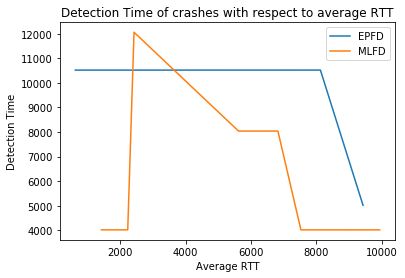

In [264]:
plt.plot(mean_n_epfd, node_suspicions_epfd["detection_time"], label="EPFD")
plt.plot(mean_n, node_suspicions["detection_time"], label="MLFD")
plt.ylabel('Detection Time')
plt.xlabel('Average RTT')
plt.title('Detection Time of crashes with respect to average RTT')
plt.legend()
plt.show()

In [276]:
node_suspicions2_epfd = pd.read_csv('../data/backup/stats_epfd/node_suspicions.csv')
keys_epfd = ['suspected', "node"]
i1_epfd = node_suspicions2_epfd.set_index(keys_epfd).index
i2_epfd = node_suspicions_epfd.set_index(keys_epfd).index
false_suspicions_epfd = node_suspicions2_epfd[~i1_epfd.isin(i2_epfd)]
false_suspicions_epfd = false_suspicions_epfd.groupby("suspected").count()
false_suspicions_epfd

,node
suspected,
1504433156016,96
1504433159076,5
1504433161096,17
1504433163616,20
1504433166636,31
1504433170156,39
1504433174176,10
1504433178696,25
1504433183715,30


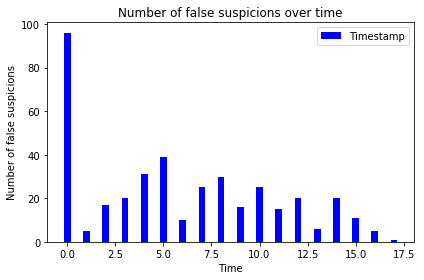

In [297]:
epfd_false_suspicions = false_suspicions_epfd.values
l = len(epfd_false_suspicions)
width = 0.35
error_config = {'ecolor': '0.3'}
plt.bar(range(len(epfd_false_suspicions)), epfd_false_suspicions, width=width, color='b', error_kw=error_config, label='Timestamp')
plt.xlabel('Time')
plt.ylabel('Number of false suspicions')
plt.title('Number of false suspicions over time')
plt.legend()
plt.tight_layout()

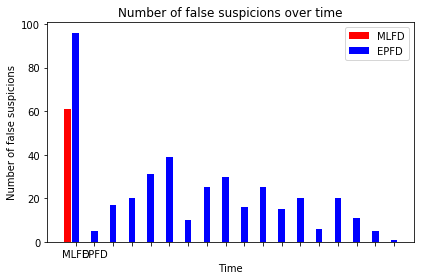

In [309]:
bar_width = 0.45
index1 = np.arange(l)
index2 = np.arange(len(mlfd_false_suspicions))
plt.bar(index2, mlfd_false_suspicions, width=width, color='r', error_kw=error_config, label='MLFD')
plt.bar(index1 + bar_width, epfd_false_suspicions, width=width, color='b', error_kw=error_config, label='EPFD')
plt.xlabel('Time')
plt.ylabel('Number of false suspicions')
plt.title('Number of false suspicions over time')
plt.legend()
plt.xticks(index1 + bar_width, ('MLFD', 'EPFD'))
plt.tight_layout()